# Assignment-1 (KNN Classifier)
## Handwritten digit recognition
In this assignment, we will build a classifier that takes an image of a handwritten digit and outputs a label 0-9.

## The MNIST dataset
`MNIST` is a classic dataset in machine learning, consisting of 28x28 gray-scale images handwritten digits. The training set contains 60,000 examples and the test set contains 10,000 examples. In this assignment we will further split the training set to take out 12,000 examples as a validation step.

In [1]:
%matplotlib inline
import gzip, os
import numpy as np
import matplotlib.pyplot as plt
import time
from urllib.request import urlretrieve

In [2]:
# Function that downloads a specified MNIST data file from Yann Le Cun's website
def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
    print("Downloading %s" % filename)
    urlretrieve(source + filename, filename)

# Invokes download() if necessary, then reads in images
def load_mnist_images(filename):
    if not os.path.exists(filename):
        download(filename)
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)
    data = data.reshape(-1,784)
    return data

def load_mnist_labels(filename):
    if not os.path.exists(filename):
        download(filename)
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=8)
    return data

In [11]:
# Training dataset dimensions:  (60000, 784)
# Number of training labels:  60000
# Testing dataset dimensions:  (10000, 784)
# Number of testing labels:  10000

## Load the training set
train_data = load_mnist_images('train-images-idx3-ubyte.gz')[:600]
train_labels = load_mnist_labels('train-labels-idx1-ubyte.gz')[:600]

## Load the testing set
test_data = load_mnist_images('t10k-images-idx3-ubyte.gz')[:100]
test_labels = load_mnist_labels('t10k-labels-idx1-ubyte.gz')[:100]

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt 
import time

## Load the training set
train_data = np.load('MNIST/train_data.npy')
train_labels = np.load('MNIST/train_labels.npy')

## Load the testing set
test_data = np.load('MNIST/test_data.npy')
test_labels = np.load('MNIST/test_labels.npy')

In [12]:
train_data = train_data.astype('int64')
test_data = test_data.astype('int64')

In [13]:
test_data.shape

(100, 784)

In [14]:
## Print out their dimensions
print("Training dataset dimensions: ", np.shape(train_data))
print("Number of training labels: ", len(train_labels))
print("Testing dataset dimensions: ", np.shape(test_data))
print("Number of testing labels: ", len(test_labels))

Training dataset dimensions:  (600, 784)
Number of training labels:  600
Testing dataset dimensions:  (100, 784)
Number of testing labels:  100


In [15]:
## Compute the number of examples of each digit
train_digits, train_counts = np.unique(train_labels, return_counts=True)
print("Training set distribution:")
print(dict(zip(train_digits, train_counts)))

test_digits, test_counts = np.unique(test_labels, return_counts=True)
print("Test set distribution:")
print(dict(zip(test_digits, test_counts)))

Training set distribution:
{0: 58, 1: 79, 2: 64, 3: 59, 4: 59, 5: 51, 6: 54, 7: 62, 8: 49, 9: 65}
Test set distribution:
{0: 8, 1: 14, 2: 8, 3: 11, 4: 14, 5: 7, 6: 10, 7: 15, 8: 2, 9: 11}


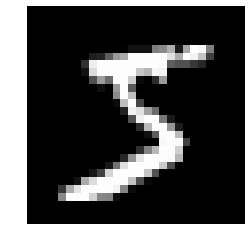

Label 5


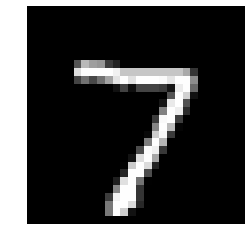

Label 7


In [16]:
## Define a function that displays a digit given its vector representation
def show_digit(x):
    plt.axis('off')
    plt.imshow(x.reshape((28,28)), cmap=plt.cm.gray)
    plt.show()
    return

## Define a function that takes an index into a particular data set ("train" or "test") and displays that image.
def vis_image(index, dataset="train"):
    if(dataset=="train"): 
        show_digit(train_data[index,])
        label = train_labels[index]
    else:
        show_digit(test_data[index,])
        label = test_labels[index]
    print("Label " + str(label))
    return

## View the first data point in the training set
vis_image(0, "train")

## Now view the first data point in the test set
vis_image(0, "test")

## Splitting the Train data to Train and Validate Sets

In [17]:
from sklearn.model_selection import train_test_split
trainx, valx, trainy, valy = train_test_split(train_data, train_labels, test_size=0.20, random_state=42)

## Nearest neighbor classification with L2 distance

To compute nearest neighbors in our data set, we need to first be able to compute distances between data points. A natural distance function is _Euclidean distance_: for two vectors $x, y \in \mathbb{R}^d$, their Euclidean distance is defined as 
$$\|x - y\| = \sqrt{\sum_{i=1}^d (x_i - y_i)^2}.$$
Often we omit the square root, and simply compute _squared Euclidean distance_:
$$\|x - y\|^2 = \sum_{i=1}^d (x_i - y_i)^2.$$
For the purposes of nearest neighbor computations, the two are equivalent: for three vectors $x, y, z \in \mathbb{R}^d$, we have $\|x - y\| \leq \|x - z\|$ if and only if $\|x - y\|^2 \leq \|x - z\|^2$.

## Solution

### Distance measures

This is a general `ln` distance measure, it can be used for l2, l1 and any ln distance by changing the ord parameter

```
np.linalg.norm(np.subtract(a, b), ord=2)
```

In [18]:
def ln_dist(a, b, n=2):
    return np.linalg.norm(np.subtract(a, b), ord=n)

def euclidean_dist(a, b):
    return np.linalg.norm(np.subtract(a, b))

### Genral NN (nearest neighbor)

This function takes in the distance measure, and the training values and labels, as well as a single test value

In [175]:
def KNN_predict(X_train, Y_train, x_test, k=None, dist=euclidean_dist, weighted=False) -> list:
    """
    @param x_test - a single entry, not a vector of Xs
    @param k - 
    @param dist - distance function
    @param weighted

    @returns the Y values
    """
    # setting default values
    import collections
    if k is None:
        k = 1
    if isinstance(dist, (int, float)):
        n = dist
        dist = lambda a,b: ln_dist(a,b, n=n)
    
    start_time = time.time()
    
    distances = [dist(x_test, x) for x in X_train]

    if k == 1:
        k_indexes = [np.argmin(distances, axis=0)]
    else:
        # index list of shortest distances
        k_indexes = np.argsort(distances, axis=0)[:k]

    if weighted is False:
        Ys = Y_train[k_indexes]
        # sorted list of item frequency
        result = sorted(Ys, key=collections.Counter(Ys).get, reverse=True)[0]
#         print('potential results: {}, {:3}s'.format(Ys, time.time()-start_time))
        return result

    # else if weighted:

#     print("potential Ys (before merging):", Y_train[k_indexes])

    # create a dict with each key as a `y` and value as voting score (and we occumulate)
    d = {} # contains {y: summed_score}
    for k_i in k_indexes: # accumulating the sum
        y = Y_train[k_i]
        if not y in d: # initialize with 0
            d[y] = 0.000001
        d[y] += distances[k_i] #TODO: this can be changed

#     print("potential Ys:", list(d.keys()))

    # then we sort the values and find the class with the highest score
    # https://stackoverflow.com/a/613218/7771202
    # returns a list of tuples sorted by the second element (the distance)
    sorted_values = sorted(d.items(), key=lambda kv: kv[1])
#     print('sorted_values', list(sorted_values))
#     print('Prediction took {:3}s'.format(time.time()-start_time))
    return sorted_values[0][0]

### General purpose KNN classifier class

The advantage of having such a class is that it's compatible with sklearn's interface (fit, train, score, get_params, set_params)

I followed the guide on [creating a custom sklearn estimator](https://scikit-learn.org/stable/developers/contributing.html#rolling-your-own-estimator) to allow for compatibility.

In [106]:
class KNNClassifier():
    def __init__(self, k=None, dist_metric=2, weighted=False):
        self.__X_train = []
        self.__Y_train = []
        
        self.k = k
        self.dist_metric = dist_metric
        self.weighted = weighted

    def fit(self, X_train, Y_train):
        self.__X_train = X_train
        self.__Y_train = Y_train
        return self

    def predict(self, X, k=None, dist=None, weighted=None) -> list:
        """
        @param x_test - the input value to be predicted, (a single entry, not a vector of Xs)
        @param k - 
        @param dist - distance function
        @param weighted

        @returns the Y values
        """
        if k is None:
            k = self.k
        if dist is None:
            dist = self.dist_metric
        if weighted is None:
            weighted = self.weighted
        
        return [KNN_predict(self.__X_train, self.__Y_train, x_test, k=k, dist=dist, weighted=weighted) for x_test in X]

    def score(self, X, y=None):
        """
        returns 1 if the answer is correct, 0 otherwise.
        This score is used for the cross validation and the grid search
        """
        return 1 if self.predict(X) == y else 0
    
    def get_params(self, deep=True):
        return {
            'k': self.k,
            'dist_metric': self.dist_metric,
            'weighted': self.weighted
        }
    
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

## 1. Nearest neighbor classification with L2 distance

Write a function, **NN_L2**, which takes as input the training data (`trainx` and `trainy`) and the test points (`evalx`) and predicts labels for these test points using 1-NN classification. These labels should be returned in a `numpy` array with one entry per test point. For **NN_L2**, the L2 norm should be used as the distance metric.

In [140]:
def NN_L2(trainx, trainy, evalx):
    # inputs: trainx, trainy, testx <-- as defined above
    # output: an np.array of the predicted values for testy 
    
    # result array contains the closest label from evalx
    # in the end, we convert it to a numpy array
    return [KNN_predict(trainx, trainy, x_test, k=1, dist=euclidean_dist, weighted=False) for x_test in evalx]


## 2. K-Nearest neighbor classification with L2 distance

Write a function, **KNN_L2**, which takes as input the training data (`trainx` and `trainy`), the test points (`evalx`), and the value of **K** (integer) and predicts labels for these test points using K-NN classification. These labels should be returned in a `numpy` array with one entry per test point.

In [141]:
def KNN_L2(trainx, trainy, evalx, K=2):
    # output: an np.array of the predicted values for testy 
    return [KNN_predict(trainx, trainy, x_test, k=K, dist=euclidean_dist, weighted=False) for x_test in evalx]


## 3. Nearest neighbor classification with L1 distance

We now compute nearest neighbors using the L1 distance (sometimes called *Manhattan Distance*).

Write a function, **NN_L1**, which again takes as input the arrays `trainx`, `trainy`, and `evalx`, and predicts labels for the test points using 1-nearest neighbor classification. For **NN_L1**, the L1 distance metric should be used. As before, the predicted labels should be returned in a `numpy` array with one entry per test point.

Notice that **NN_L1** and **NN_L2** may well produce different predictions on the test set.

In [146]:
def NN_L1(trainx, trainy, evalx):
    # inputs: trainx, trainy, testx <-- as defined above
    # output: an np.array of the predicted values for testy 
    return [KNN_predict(trainx, trainy, x_test, k=1, dist=2, weighted=False) for x_test in evalx]


## 4. K-Nearest neighbor classification with L1 distance

Write a function, **KNN_L1**, which takes as input the training data (`trainx` and `trainy`), the test points (`evalx`), and the value of **K** (integer) and predicts labels for these test points using K-NN classification and L1 distance metric. These labels should be returned in a `numpy` array with one entry per test point.

In [143]:
def KNN_L1(trainx, trainy, evalx, K=2):
    # output: an np.array of the predicted values for testy 
    return [KNN_predict(trainx, trainy, x_test, k=K, dist=1, weighted=False) for x_test in evalx]

## 5. K-Nearest neighbor classifier

Write a function, **KNN**, which takes as input the training data (`trainx` and `trainy`), the test points (`evalx`), the value of **K** (integer), and a parameter for deciding the distance metric to be used (fr example 1 for L1 and 2 for L2) and predicts labels for these test points using KNN classification. These labels should be returned in a `numpy` array with one entry per test point.

In [144]:
def KNN(trainx, trainy, evalx, K=4, dist_metric=2, weighted=False):
    # output: an np.array of the predicted values for testy 
    return [KNN_predict(trainx, trainy, x_test, k=K, dist=dist_metric, weighted=False) for x_test in evalx]

## 6. Putting it all together

Write code that allows you to select the hyper-parameters (distance measure and the value of K) by calling the KNN classifier with different values of K and either L1 or L2 distance measure. Make sure that you set the hyper-parameters using the development set and not the test set.

- [ ] You need to systemtically try different values for K in conjunction with a distance measure and tabulate the results (in the assignment report) and not down the best hyper-parameter settings.

In [112]:
from sklearn.metrics import accuracy_score

### hyper parameter search

We could either do a manual search or a grid-search, since our implemented `KNNClassifier` is compatible with sklearn's gridsearch, we can use that.

We will use grid-search to iterate over all hyperparameters. For each one we will record the hyperparams and the result, the training will be using the reduced training set, and testing on the validation set.

#### Manual grid search

the bellow cell generates all the combinations for the hyperparams

In [113]:
import itertools

param_grid = {
    'K': [2, 4, 10, 100],
    'dist_metric': [1, 2],
    'weighted': [False]
}

index2key = dict(enumerate(param_grid))

param_combos = []
for i, combo in enumerate(itertools.product(*param_grid.values())): #finding the product (all combinations)
    params = {index2key[i] : val for i, val in enumerate(combo)} # create a hyperparam dictionary
    param_combos.append(params)

print('all combinations of hyperparams to try:\n', param_combos)
    

all combinations of hyperparams to try:
 [{'K': 2, 'dist_metric': 1, 'weighted': False}, {'K': 2, 'dist_metric': 2, 'weighted': False}, {'K': 4, 'dist_metric': 1, 'weighted': False}, {'K': 4, 'dist_metric': 2, 'weighted': False}, {'K': 10, 'dist_metric': 1, 'weighted': False}, {'K': 10, 'dist_metric': 2, 'weighted': False}, {'K': 100, 'dist_metric': 1, 'weighted': False}, {'K': 100, 'dist_metric': 2, 'weighted': False}]


In [151]:
results = {}

knn_clf = KNNClassifier() # passing the keyword arguments (**kwargs)

for i, hyperparams in enumerate(param_combos, start=1):
    start_time = time.time()
    
    knn_clf.set_params(**hyperparams) # set hyperparams
    knn_clf.fit(trainx, trainy) # fit the data
    pred = knn_clf.predict(valx) # predict
    results[i] = {
        'score': accuracy_score(valy, pred),
        'time': time.time() - start_time,
        'pred': pred,
        'params': hyperparams
    }
    print('({}/{}) {:.3}seconds.\t For hyperparams: {}, score={:.4}'.format(
        i, len(param_combos), #progress
        time.time() - start_time, # time
        hyperparams, # hyperparams
        results[i]['score'] # results dict
    ))

    # once we're done with checking those values, 

(1/8) 0.565seconds.	 For hyperparams: {'K': 2, 'dist_metric': 1, 'weighted': False}, score=0.8167
(2/8) 0.555seconds.	 For hyperparams: {'K': 2, 'dist_metric': 2, 'weighted': False}, score=0.8333
(3/8) 0.545seconds.	 For hyperparams: {'K': 4, 'dist_metric': 1, 'weighted': False}, score=0.8167
(4/8) 0.476seconds.	 For hyperparams: {'K': 4, 'dist_metric': 2, 'weighted': False}, score=0.8333
(5/8) 0.553seconds.	 For hyperparams: {'K': 10, 'dist_metric': 1, 'weighted': False}, score=0.8167
(6/8) 0.477seconds.	 For hyperparams: {'K': 10, 'dist_metric': 2, 'weighted': False}, score=0.8333
(7/8) 0.549seconds.	 For hyperparams: {'K': 100, 'dist_metric': 1, 'weighted': False}, score=0.8167
(8/8) 0.508seconds.	 For hyperparams: {'K': 100, 'dist_metric': 2, 'weighted': False}, score=0.8333


In [129]:
# sorting by highest score
best_result = list(reversed(sorted(results.items(), key=lambda item: item[1]['score'])))[0][1]

In [130]:
best_params = best_result['params']
print('best_params', best_params)

best_params {'K': 100, 'dist_metric': 2, 'weighted': False}


#### Using Scikit learn's [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV)

`class sklearn.model_selection.GridSearchCV(estimator, param_grid, scoring=None, n_jobs=None, iid=’warn’, refit=True, cv=’warn’, verbose=0, pre_dispatch=‘2*n_jobs’, error_score=’raise-deprecating’, return_train_score=False)`

In [131]:
# from sklearn.model_selection import GridSearchCV

# knn_clf = KNNClassifier()
# # GridSearchCV(estimator, param_grid, scoring=None, n_jobs=None, iid=’warn’, refit=True, cv=’warn’, verbose=0, pre_dispatch=‘2*n_jobs’, error_score=’raise-deprecating’, return_train_score=False)
# gridSearchCV = GridSearchCV(knn_clf, param_grid, n_jobs=6, verbose=3)

# gridSearchCV.fit(trainx, trainy)
# # uses 3-fold cross validation

In [132]:
# sorted(gridSearchCV.cv_results_.keys())

In [133]:
# cv_clf.get_params()

# 7. Test errors and the confusion matrix

Once the hyper-parameters have been selected, we now would like to perform a final evaluation on the test set and record the error rates. Also, Write a function, **confusion**, which takes as input the true labels for the test set (that is, `testy`) as well as the predicted labels and returns the confusion matrix. The confusion matrix should be a `np.array` of shape `(10,10)`. Also, record the confusion matrix in your assignment report.

**Note:** Record the cpu time it takes to perform the evaluation on the test set using functions like **time.time()**.

In [121]:
def confusion(testy, testy_fit):
    # inputs: the correct labels, the fitted KNN labels 
    # output: a 10x10 np.array representing the confusion matrix as above
    cm = np.zeros((10, 10))
    #TODO:
    for y, x in zip(range(cm.shape[0]), range(cm.shape[1])):
        cm[x, y] = testy[x]
        cm[y, x] = testy_fit[x]
    return cm

In [122]:
# code from: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [149]:
# Code for performing the final evaluation on the test set and generating the confuson matrix.
### START CODE HERE ###

test_results = {}
# NN_L2
# What is the best error rate on the validation set for KNN_L2?
# What is the error rate on the validation set for NN_L1?
# What is the best error rate on the validation set for KNN_L1?

funcs = ['NN_L2', 'KNN_L2', 'NN_L1', 'KNN_L1']

for i, func_name in enumerate(funcs):
    func = eval(func_name)
    start_time = time.time()
    pred = func(trainx, trainy, valx)
    
    score = accuracy_score(valy, pred)
    test_results[i] = {
        'name': func_name,
        'score': score,
        'error': 1 - score,
        'time': time.time() - start_time,
        'pred': pred
    }

### END CODE HERE ###

In [148]:
import matplotlib.pyplot as plt

#TODO:
for i in test_results:
    r = test_results[i]
    plt.figure()
    plt.title(r['name'])
    
    plt.plot()
    plt.show()

Confusion matrix, without normalization
[[ 6  0  0  1  0  0  0  1  0  0]
 [ 0 13  0  0  0  1  0  0  0  0]
 [ 0  1  4  0  0  0  0  1  2  0]
 [ 1  0  1  2  0  3  1  2  1  0]
 [ 1  0  0  1  4  3  0  5  0  0]
 [ 2  0  0  2  2  1  0  0  0  0]
 [ 0  1  0  0  0  2  4  2  1  0]
 [ 0  0  0  1  0  1  0 13  0  0]
 [ 0  0  1  0  0  0  1  0  0  0]
 [ 0  1  0  0  0  1  0  2  0  7]]


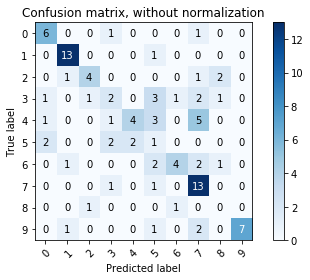

In [176]:
# testing training:
# trainx, valx, trainy, valy
y_pred = KNN(train_data, train_labels, test_data, K=10, dist_metric=float('inf'))
accuracy_score(test_labels, y_pred)
plot_confusion_matrix(test_labels, y_pred, np.array([0,1,2,3,4,5,6,7,8,9]))

## 8. Faster nearest neighbor methods

Performing nearest neighbor classification in the way we have presented requires a full pass through the training set in order to classify a single point. If there are $N$ training points in $\mathbb{R}^d$, this takes $O(N d)$ time.

Fortunately, there are faster methods to perform nearest neighbor look up if we are willing to spend some time preprocessing the training set. `scikit-learn` has fast implementations of two useful nearest neighbor data structures: the _ball tree_ and the _k-d tree_. Study the KDTree and use it to make KNN predictions.
- [ ] Record the error rates on the test set and the cpu time taken for evaluation.

**Note:** Here you don't have to implement teh KDTree but just you need to use it from ``sklearn`` library.

Documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KDTree.html)

In [169]:
from sklearn.neighbors import KDTree
### START CODE HERE ###
np.set_printoptions(threshold=np.inf)

tree = KDTree(trainx)
dist, indx = tree.query(valx, k=5)
print(indx)
# print(dist)
x_result = np.zeros(len(valx)) # for saving the most frequent data point obtained from indx[]
y_result = np.zeros(len(valx)) # for saving the prediction
for i, x in enumerate(indx):
    x_result[i] =  int (np.bincount(x).argmax()) # saving the most frequent data point
    y_result[i] = trainy[ int (x_result[i])] # saving the corresponding label

y_result = y_result.astype(int)

print("predictions: ")
print(y_result)
print("Actual:")
print(valy)

print('score:', accuracy_score(y_result, valy))

### END CODE HERE ###

predictions: 
[4 9 6 1 3 3 3 8 1 7 9 0 1 1 4 0 3 7 1 3 4 1 1 0 8 8 1 3 1 5 9 4 2 4 0 0 1
 2 9 4 9 7 6 2 1 3 0 1 0 3 8 1 7 2 2 9 0 6 1 9 2 4 4 6 2 1 3 9 0 8 4 1 9 9
 0 5 8 6 8 4 6 7 6 3 6 6 6 6 1 0 3 2 4 1 5 9 4 5 9 6 6 1 1 5 7 4 9 3 7 6 2
 0 8 4 7 0 9 9 0 8]
Actual:
[9 9 6 1 3 5 3 8 1 7 8 0 2 2 4 0 3 7 1 3 4 1 1 0 8 8 1 3 1 5 9 4 2 4 0 0 5
 2 9 4 9 7 6 2 1 5 0 1 0 3 8 1 7 2 2 3 0 6 8 9 2 9 4 6 2 1 3 9 0 5 9 1 9 9
 0 5 8 6 8 2 6 7 6 3 6 6 6 6 7 0 3 3 4 8 5 9 3 5 4 6 6 1 1 5 7 9 7 3 2 4 2
 0 8 2 7 0 7 7 6 8]
score: 0.7833333333333333


## 9. Preparing the assignment report

You need to prepare the assignment report and submit your code and report to the Blackboard assignment. You need to record your answers for the following questions in the report:
1. What is the error rate on the validation set for NN_L2?
2. What is the best error rate on the validation set for KNN_L2?
3. What is the error rate on the validation set for NN_L1?
4. What is the best error rate on the validation set for KNN_L1?
5. What is the error rate on the test set?
6. Which digit class has the most errorrs? And, with which class does it get the most confused? Do you have ideas to fix this problem?


#### 9. Answer
usually predicts 9 when the actual value is 7, it also tends to confuse 0 with 2

## 10. Extra Stuff

You are invited to try some more ideas as extra work like:
- [x] Implementing weighted KNN where the vote of a neighbour is scaled down based on its distance from the test point.
- [x] Implement L_infinity distance measure and use it for classification.
- [ ] Instead of using the pixels as features, implement your own features (example: what were presented in the slides) and use them for KNN. You need to keep in mind that if you compute features which have different scales then it is important to scale/normalize the features (discussed in the slides).

### Trying new features
Here we go trying new features, let's try to sum up the number of pixels in the column vectors of the images.


Then we subtract the corresponding column counts.

Confusion matrix, without normalization
[[ 8  0  0  0  0  0  0  0  0  0]
 [14  0  0  0  0  0  0  0  0  0]
 [ 8  0  0  0  0  0  0  0  0  0]
 [11  0  0  0  0  0  0  0  0  0]
 [14  0  0  0  0  0  0  0  0  0]
 [ 7  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [15  0  0  0  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  0  0  0]
 [11  0  0  0  0  0  0  0  0  0]]


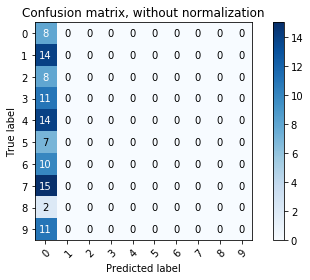

In [179]:
# testing training:
# trainx, valx, trainy, valy
def custom_feature_distance(a, b, **kwargs):
    # counting the horizontal lines, and passing the number of white pixels as the distance
    a_sum = [sum(col) for col in a.reshape(28, 28)]
    b_sum = [sum(col) for col in b.reshape(28, 28)]
    return sum(np.subtract(a_sum, b_sum))

y_pred = KNN(train_data, train_labels, test_data, K=10, dist_metric=custom_feature_distance)
accuracy_score(test_labels, y_pred)
plot_confusion_matrix(test_labels, y_pred, np.array([0,1,2,3,4,5,6,7,8,9]))

#### Conclusion
This is a horrible feature, don't do it

In [180]:
def L_infinity(a,b):
    return  #TODO: